In [ ]:
#! importing libraries

import torch
import numpy as np
from google.colab import drive
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
#! mounting google drive
drive.mount('/content/drive')

#! defining paths
dataset_path = '/content/drive/MyDrive/TomatoPlantfactoryDataset'
images_path = os.path.join(dataset_path, 'Images')
labels_path = os.path.join(dataset_path, 'labels')
annotations_path = os.path.join(dataset_path, 'Annotations')

Mounted at /content/drive


In [4]:
#! loading tomato counts from label files
def load_labels(labels_path):
    labels = {}
    #! iterating over each file in the labels directory
    for file_name in os.listdir(labels_path):
        if file_name.endswith('.txt'):
            file_path = os.path.join(labels_path, file_name)
            tomato_count = 0
            #! opening each file and counting occurences of label '1' - tomato
            with open(file_path, 'r') as file:
                for line in file:
                    label_id = line.strip().split()[0]  # First item is label ID
                    if label_id == '1':  # Assuming '1' is the label for tomatoes
                        tomato_count += 1
            #! replacing .txt with .jpg in the filename to mtch with the images
            image_name = file_name.replace('.txt', '.jpg')
            labels[image_name] = tomato_count
    return labels

#! loading labels and print for verification
labels_dict = load_labels(labels_path)
print("Sample labels:", list(labels_dict.items())[:5])

Sample labels: [('0001.jpg', 10), ('0002.jpg', 39), ('0000.jpg', 0), ('0003.jpg', 0), ('0004.jpg', 0)]


In [5]:
#! loading tomato counts from label files, counting instances labeled as '1' - tomato
def load_labels(labels_path):
    labels = {}
    #! # iterating over each file in the labels directory
    for file_name in os.listdir(labels_path):
        if file_name.endswith('.txt'):
            file_path = os.path.join(labels_path, file_name)
            tomato_count = 0
            #! opening each file and count occurrences of label '1' (indicating a tomato)
            with open(file_path, 'r') as file:
                for line in file:
                    label_id = line.strip().split()[0]  #! first item is label ID
                    if label_id == '1':  #! assuming '1' is the label for tomatoes
                        tomato_count += 1
            #! adjust the extension from .txt to .jpg to match the images
            image_name = file_name.replace('.txt', '.JPG')
            labels[image_name] = tomato_count
    return labels

#! loading labels
labels_dict = load_labels(labels_path)

#! filtering to ensure only images that exist in the folder are kept in labels_dict
labels_dict = {img: count for img, count in labels_dict.items() if os.path.exists(os.path.join(images_path, img))}
print("Filtered labels dictionary size:", len(labels_dict))

Filtered labels dictionary size: 520


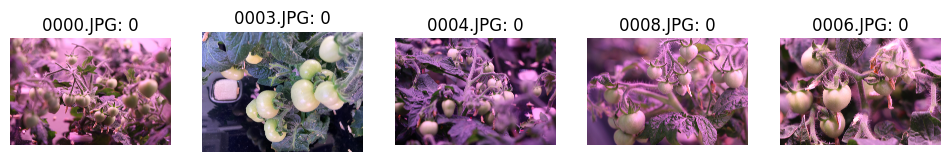

In [9]:
#! finding images with zero tomatoes
zero_tomato_images = [img for img, count in labels_dict.items() if count == 0]

#! setting up figure for displaying a sample of zero-tomato image
plt.figure(figsize=(12, 6))
for i, img_name in enumerate(zero_tomato_images[:5]):  #! showing only first 5 for brevity
    img_path = os.path.join(images_path, img_name)    #! full path to the image file
    img = Image.open(img_path)    #! openeing the image
    #! plotting each image
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f"{img_name}: {labels_dict[img_name]}")
    plt.axis('off')
plt.show()

In [14]:
#! custom dataset class for loading images and their corresponding tomato counts
class TomatoDataset(Dataset):
    def __init__(self, images_path, labels_dict, transform=None):
        self.images_path = images_path
        self.labels_dict = labels_dict
        self.image_names = list(labels_dict.keys())    #! list of image names to maintain order
        self.transform = transform    #! transformations to be applied to each image

    def __len__(self):
      #! returning the total number of images
        return len(self.image_names)

    def __getitem__(self, idx):
      #! retrives image and label given the index
        img_name = self.image_names[idx]    #! getting image name and path
        img_path = os.path.join(self.images_path, img_name)

        #! loading image
        image = Image.open(img_path).convert('RGB')    #! converting to RGB format
        label = self.labels_dict[img_name]    #! retriving tomato count for image

        #! applying transformations
        if self.transform:
            image = self.transform(image)

        return image, label

#! defining transformations: resizing image and converting to tensor
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [15]:
#! initializing dataset with transformation
dataset = TomatoDataset(images_path, labels_dict, transform=transform)

#! given 80-20 split
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size

train_dataset = torch.utils.data.Subset(dataset, list(range(0, train_size)))
val_dataset = torch.utils.data.Subset(dataset, list(range(train_size, total_size)))

In [16]:
#! creating DataLoaders

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [17]:
#! CNN for predicting tomato count in an image

class TomatoCountCNN(nn.Module):
    def __init__(self):
        super(TomatoCountCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)    #! first convo layer: 32 filers, 3x3 kernel, relu activation
        self.pool = nn.MaxPool2d(2, 2)    #! max pooling layer to downsample the feature map size by half
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)    #! second convolutional layer: 64 filters, 3x3 kernel, ReLU activation
        self.fc1 = nn.Linear(64 * 56 * 56, 128)    #! first fully connected layer with 128 neurons
        self.fc2 = nn.Linear(128, 1)  #! putput layer for regression

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))    #! applying first convolutional layer followed by ReLU and pooling
        x = self.pool(torch.relu(self.conv2(x)))    #! applying second convolutional layer followed by ReLU and pooling
        x = x.view(-1, 64 * 56 * 56)  #! flatten
        x = torch.relu(self.fc1(x))    #! applying the first fully connected layer with ReLU activation
        x = self.fc2(x)    #! output layer
        return x

In [18]:
#! initializing model, loss function, and optimizer
model = TomatoCountCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

TomatoCountCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

Epoch [1/20], Train Loss: 113.3812, Validation Loss: 95.8568
Epoch [2/20], Train Loss: 61.1157, Validation Loss: 69.4270
Epoch [3/20], Train Loss: 49.6167, Validation Loss: 57.0252
Epoch [4/20], Train Loss: 39.1890, Validation Loss: 46.4031
Epoch [5/20], Train Loss: 26.1802, Validation Loss: 39.3584
Epoch [6/20], Train Loss: 20.1313, Validation Loss: 34.6529
Epoch [7/20], Train Loss: 17.3170, Validation Loss: 31.4108
Epoch [8/20], Train Loss: 12.7871, Validation Loss: 31.0668
Epoch [9/20], Train Loss: 8.3529, Validation Loss: 31.5149
Epoch [10/20], Train Loss: 5.1617, Validation Loss: 32.9278
Epoch [11/20], Train Loss: 4.1431, Validation Loss: 31.2029
Epoch [12/20], Train Loss: 2.2696, Validation Loss: 33.1735
Epoch [13/20], Train Loss: 1.3431, Validation Loss: 32.0895
Epoch [14/20], Train Loss: 0.9359, Validation Loss: 30.7464
Epoch [15/20], Train Loss: 0.8720, Validation Loss: 32.9510
Epoch [16/20], Train Loss: 0.6093, Validation Loss: 31.8294
Epoch [17/20], Train Loss: 0.3454, Valid

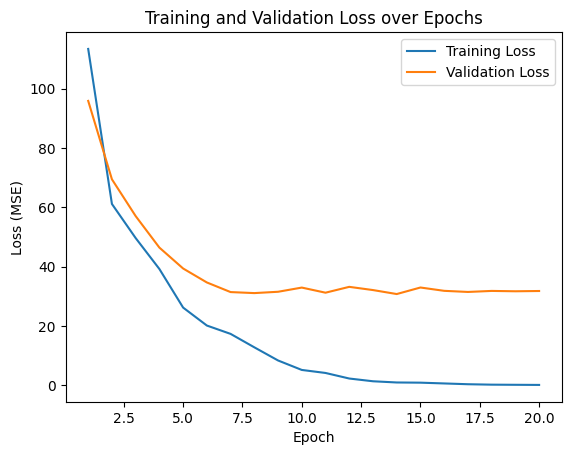

In [19]:
#! number of epochs given
num_epochs = 20
train_losses = []    #! to store training loss values over each epoch
val_losses = []    #! #! to store validation loss values over each epoch

for epoch in range(num_epochs):
    #! training phase
    model.train()    #! setting the model to training mode
    running_train_loss = 0.0

    #! iterating over batches for training data
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device, dtype=torch.float32)

        optimizer.zero_grad()    #! clearning gradients from previous steps
        outputs = model(images).squeeze()    #! forward pass
        loss = criterion(outputs, labels)    #! computing loss between predictions and true labels
        loss.backward()   #! backpropogation
        optimizer.step()    #! update model params

        running_train_loss += loss.item()

    #! calculating average training loss for the epoch
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    #! validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device, dtype=torch.float32)
            outputs = model(images).squeeze()    #! forward pass
            val_loss = criterion(outputs, labels)    #! computing validation loss
            running_val_loss += val_loss.item()    #! accumulating validation loss

    #! calculating average validation loss for the epoch
    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

#! plotting training and validation loss over epochs
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [20]:
#! setting model to evaluation mode
model.eval()
val_labels = []    #! storing true tomato counts for valiation
val_preds = []    #! soring predicted model counts

with torch.no_grad():
    for images, labels in val_loader:
      #! moving images to CPU  or GPU
        images = images.to(device)
        outputs = model(images).squeeze()    #! forward pass

        val_preds.extend(outputs.cpu().numpy())
        val_labels.extend(labels.numpy())

In [24]:
#! calculate MAE and RMSE
mae = mean_absolute_error(val_labels, val_preds)
rmse = np.sqrt(mean_squared_error(val_labels, val_preds))
print(f"Validation MAE: {mae:.2f}")
print(f"Validation RMSE: {rmse:.2f}")

Validation MAE: 2.81
Validation RMSE: 6.11


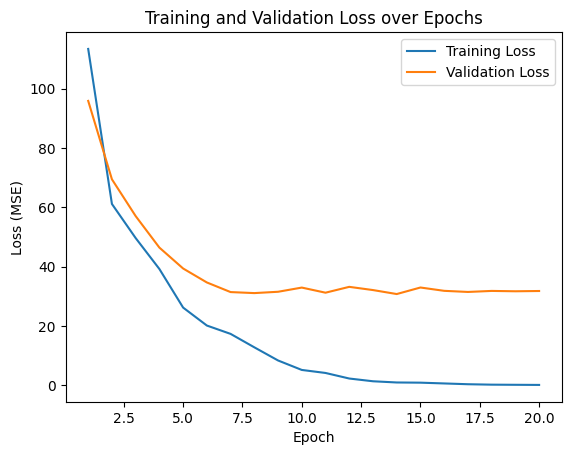

In [25]:
#! plotting training and validation loss
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

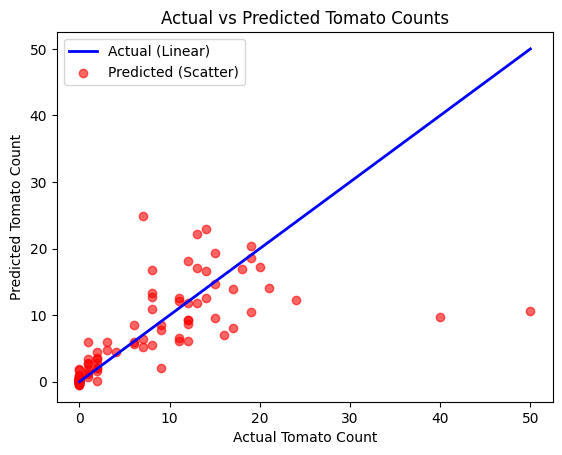

In [26]:
#! converting lists to numpy arrays for easier manipulation
val_labels = np.array(val_labels)
val_preds = np.array(val_preds)

#! sorting actual values and corresponding predictions for a smooth line
sorted_indices = np.argsort(val_labels)
sorted_labels = val_labels[sorted_indices]
sorted_preds = val_preds[sorted_indices]

#! plotting the actual values as a linear line
plt.plot(sorted_labels, sorted_labels, color='blue', label='Actual', linewidth=2)

#! scattered plot of predicted values against actual values
plt.scatter(sorted_labels, sorted_preds, color='red', alpha=0.6, label='Predicted')

#! labels and legend
plt.xlabel("Actual Tomato Count")
plt.ylabel("Predicted Tomato Count")
plt.title("Actual vs Predicted Tomato Counts")
plt.legend()
plt.show()